# Visual-language assistant using DeepSeek-VL2 and OpenVINO

DeepSeek-VL2 is an advanced series of large Mixture-of-Experts (MoE) Vision-Language models. . DeepSeek-VL2 demonstrates superior capabilities across various tasks, including but not limited to visual question answering, optical character recognition, document/table/chart understanding, and visual grounding.

More details can be found in the [paper](https://arxiv.org/abs/2412.10302) and original [repository](https://github.com/deepseek-ai/DeepSeek-VL2).

In this tutorial we consider how to convert and run DeepSeek-VL2 models using [OpenVINO](https://github.com/openvinotoolkit/openvino) and optimize it using [NNCF](https://github.com/openvinotoolkit/nncf).

#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Convert model to OpenVINO Intermediate Representation](#Convert-model-to-OpenVINO-Intermediate-Representation)
    - [Compress model weights to 4-bit](#Compress-model-weights-to-4-bit)
    - [Prepare inference pipeline](#Prepare-inference-pipeline)
- [Run model inference](#Run-model-inference)
    - [Visual Grounding](#Visual-Grounding)
    - [Grounding Conversation](#Grounding-Conversation)
    - [Visual Question Answering](#Visual-Question-Answering)
- [Interactive demo](#Interactive-demo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/deepseek-vl2/deepseek-vl2.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)


In [1]:
# import requests
# from pathlib import Path

# utility_files = ["cmd_helper.py", "notebook_utils.py", "pip_helper.py"]
# base_utility_url = "https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/"

# for utility in utility_files:
#     if not Path(utility).exists():
#         r = requests.get(base_utility_url + utility)
#         with open(utility, "w", encoding="utf-8") as f:
#             f.write(r.text)

# helper_files = ["ov_deepseek_vl_helper.py", "modeling_helper.py", "gradio_helper.py"]
# base_helper_url = "https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/deepseek-vl2/"

# for helper in helper_files:
#     if not Path(helper).exists():
#         r = requests.get(base_helper_url + helper)
#         with open(helper, "w", encoding="utf-8") as f:
#             f.write(r.text)

In [2]:
# from pip_helper import pip_install
# import platform

# pip_install("-U", "openvino>=2025.0", "nncf>=2.15")
# pip_install(
#     "-q",
#     "torch>=2.1",
#     "torchvision",
#     "gradio>=4.19",
#     "einops",
#     "transformers>=4.48.2",
#     "timm>=0.9.16",
#     "accelerate",
#     "sentencepiece",
#     "attrdict",
#     "mdtex2html",
#     "pypinyin",
#     "tiktoken",
#     "tqdm",
#     "colorama",
#     "Pygments",
#     "markdown",
#     "--extra-index-url",
#     "https://download.pytorch.org/whl/cpu",
# )

# if platform.system() == "Darwin":
#     pip_install("numpy<2.0")

In [1]:
# from ov_deepseek_vl_helper import prepare_model_repo

# # Read more about telemetry collection at https://github.com/openvinotoolkit/openvino_notebooks?tab=readme-ov-file#-telemetry
# from notebook_utils import collect_telemetry

# collect_telemetry("deepseek-vl2.ipynb")

# prepare_model_repo()

## Convert model to OpenVINO Intermediate Representation
[back to top ⬆️](#Table-of-contents:)


DeepSeek-VL2 is PyTorch model. OpenVINO supports PyTorch models via conversion to OpenVINO Intermediate Representation (IR). [OpenVINO model conversion API](https://docs.openvino.ai/2024/openvino-workflow/model-preparation.html#convert-a-model-with-python-convert-model) should be used for these purposes. `ov.convert_model` function accepts original PyTorch model instance and example input for tracing and returns `ov.Model` representing this model in OpenVINO framework. Converted model can be used for saving on disk using `ov.save_model` function or directly loading on device using `core.complie_model`. 

The script `ov_deepseek_vl_helper.py` contains helper function for model conversion, please check its content if you interested in conversion details.

<details>
  <summary><b>Click here for more detailed explanation of conversion steps</b></summary>
DeepSeek-VL2 is autoregressive transformer generative model, it means that each next model step depends from model output from previous step. The generation approach is based on the assumption that the probability distribution of a word sequence can be decomposed into the product of conditional next word distributions. In other words, model predicts the next token in the loop guided by previously generated tokens until the stop-condition will be not reached (generated sequence of maximum length or end of string token obtained). The way the next token will be selected over predicted probabilities is driven by the selected decoding methodology. You can find more information about the most popular decoding methods in this <a href="https://huggingface.co/blog/how-to-generate">blog</a>. The entry point for the generation process for models from the Hugging Face Transformers library is the `generate` method. You can find more information about its parameters and configuration in the  <a href="https://huggingface.co/docs/transformers/v4.26.1/en/main_classes/text_generation#transformers.GenerationMixin.generate">documentation</a>. To preserve flexibility in the selection decoding methodology, we will convert only model inference for one step.

DeepSeek-VL2 model consists of 3 parts:

* **Vision Model** for encoding input images into embedding space.
* **Embedding Model** for conversion input text tokens into embedding space.
* **Language Model** for generation answer based on input embeddings provided by Image Encoder and Input Embedding models.

</details>


### Compress model weights to 4-bit
[back to top ⬆️](#Table-of-contents:)


For reducing memory consumption, weights compression optimization can be applied using [NNCF](https://github.com/openvinotoolkit/nncf). 

<details>
    <summary><b>Click here for more details about weight compression</b></summary>
Weight compression aims to reduce the memory footprint of a model. It can also lead to significant performance improvement for large memory-bound models, such as Large Language Models (LLMs). LLMs and other models, which require extensive memory to store the weights during inference, can benefit from weight compression in the following ways:

* enabling the inference of exceptionally large models that cannot be accommodated in the memory of the device;

* improving the inference performance of the models by reducing the latency of the memory access when computing the operations with weights, for example, Linear layers.

[Neural Network Compression Framework (NNCF)](https://github.com/openvinotoolkit/nncf) provides 4-bit / 8-bit mixed weight quantization as a compression method primarily designed to optimize LLMs. The main difference between weights compression and full model quantization (post-training quantization) is that activations remain floating-point in the case of weights compression which leads to a better accuracy. Weight compression for LLMs provides a solid inference performance improvement which is on par with the performance of the full model quantization. In addition, weight compression is data-free and does not require a calibration dataset, making it easy to use.

`nncf.compress_weights` function can be used for performing weights compression. The function accepts an OpenVINO model and other compression parameters. Compared to INT8 compression, INT4 compression improves performance even more, but introduces a minor drop in prediction quality.

More details about weights compression, can be found in [OpenVINO documentation](https://docs.openvino.ai/2024/openvino-workflow/model-optimization-guide/weight-compression.html).
</details>

In [1]:
from ov_deepseek_vl_helper import model_ids
import ipywidgets as widgets

model_selector = widgets.Dropdown(options=model_ids, value=model_ids[0], description="Model")

model_selector

Dropdown(description='Model', options=('deepseek-ai/deepseek-vl2-tiny', 'deepseek-ai/deepseek-vl2-small'), val…

In [2]:
to_compress = widgets.Checkbox(value=True, description="Compression")
to_compress

Checkbox(value=True, description='Compression')

In [3]:
# from ov_deepseek_vl_helper import convert_deepseek_vl

# # uncomment the line to see conversion code
# # ??convert_deepseek_vl

In [4]:
# import sys

# site_packages_path = r"C:\Users\LEEJEJOON\miniconda3\envs\openvino_env\Lib\site-packages"
# sys.path.insert(0, site_packages_path)

# import timm  # timm import 성공

# # 2. import 끝났으면 site-packages 다시 제거
# sys.path.remove(site_packages_path)

# import nncf
# from pathlib import Path
# quantization_config = None

# if to_compress.value:
#     quantization_config = {
#         "vision": {"mode": nncf.CompressWeightsMode.INT8_ASYM},
#         "llm": {"mode": nncf.CompressWeightsMode.INT4_SYM, "group_size": 64 if "tiny" in model_selector.value else -1, "ratio": 1.0},
#     }

# model_path = Path(model_selector.value.split("/")[-1]) / ("FP16" if not to_compress.value else "INT4")

# convert_deepseek_vl(model_selector.value, model_path=model_path, quantization_config=quantization_config)

<!-- ### Prepare inference pipeline
[back to top ⬆️](#Table-of-contents:)


`OVDeepseekVL2ForCausalLM` class defined in `ov_deepseek_vl_helper.py` represents model inference class. It accepts path to model directory and target device for inference, like original pipeline, `OVDeepseekVL2ForCausalLM` has `generate` method for getting answers. Besides that, it is compatible with original model processor class for preparing input. -->

In [5]:
from ov_deepseek_vl_helper import convert_deepseek_vl
import timm 
import nncf
from pathlib import Path
import sys
model_path = Path(model_selector.value.split("/")[-1]) / ("FP16" if not to_compress.value else "INT4")

In [6]:
from ov_deepseek_vl_helper import OVDeepseekVLV2ForCausalLM

# uncommet the line to see model class code
# ??OVDeepseekVLV2ForCausalLM

In [7]:
from notebook_utils import device_widget

device = device_widget(default="CPU", exclude=["NPU"])

device

Dropdown(description='Device:', options=('CPU', 'AUTO'), value='CPU')

In [8]:
sys.path.append('./DeepSeek-VL2')
from deepseek_vl2.models import DeepseekVLV2Processor

ov_model = OVDeepseekVLV2ForCausalLM(model_path, device.value)
processor = DeepseekVLV2Processor.from_pretrained(model_path)

Python version is above 3.10, patching the collections module.
Add pad token = ['<｜▁pad▁｜>'] to the tokenizer
<｜▁pad▁｜>:2
Add image token = ['<image>'] to the tokenizer
<image>:128815
Add grounding-related tokens = ['<|ref|>', '<|/ref|>', '<|det|>', '<|/det|>', '<|grounding|>'] to the tokenizer with input_ids
<|ref|>:128816
<|/ref|>:128817
<|det|>:128818
<|/det|>:128819
<|grounding|>:128820
Add chat tokens = ['<|User|>', '<|Assistant|>'] to the tokenizer with input_ids
<|User|>:128821
<|Assistant|>:128822



## Run model inference
[back to top ⬆️](#Table-of-contents:)


Let's check model prediction for popular tasks.

In [9]:
# import sys
# print(sys.executable)

C:\Users\LEEJEJOON\miniconda3\envs\openvino_env\python.exe


In [15]:
    sys.path.append(r"C:\Users\LEEJEJOON\Desktop\openvino\openvino_notebooks\notebooks\deepseek-vl2\DeepSeek-VL2")
    from deepseek_vl2.serve.app_modules.presets import BOX2COLOR


    import PIL
    import re

    
    
    def parse_ref_bbox(response, image: PIL.Image.Image):
        try:
            image = image.copy()
            image_h, image_w = image.size
            draw = PIL.ImageDraw.Draw(image)
    
            ref = re.findall(r"<\|ref\|>.*?<\|/ref\|>", response)
            bbox = re.findall(r"<\|det\|>.*?<\|/det\|>", response)
            assert len(ref) == len(bbox)
    
            if len(ref) == 0:
                return None
    
            boxes, labels = [], []
            for box, label in zip(bbox, ref):
                box = box.replace("<|det|>", "").replace("<|/det|>", "")
                label = label.replace("<|ref|>", "").replace("<|/ref|>", "")
                box = box[1:-1]
                for onebox in re.findall(r"\[.*?\]", box):
                    boxes.append(eval(onebox))
                    labels.append(label)
    
            for indice, (box, label) in enumerate(zip(boxes, labels)):
                box = (
                    int(box[0] / 999 * image_h),
                    int(box[1] / 999 * image_w),
                    int(box[2] / 999 * image_h),
                    int(box[3] / 999 * image_w),
                )
    
                box_color = BOX2COLOR[indice % len(BOX2COLOR.keys())]
                box_width = 3
                draw.rectangle(box, outline=box_color, width=box_width)
    
                text_x = box[0]
                text_y = box[1] - 20
                text_color = box_color
                font = PIL.ImageFont.truetype("DeepSeek-VL2/deepseek_vl2/serve/assets/simsun.ttc", size=20)
                draw.text((text_x, text_y), label, font=font, fill=text_color)
    
            return image
        except Exception:
            return None

### Visual Grounding
[back to top ⬆️](#Table-of-contents:)


Visual Grounding (VG) aims to locate the most relevant object or region in an image, based on a natural language query. The query can be a phrase, a sentence, or even a multi-round dialogue. Model supports special pattern `<|ref|>{grounding object}</|ref|>` for identification of specified grounding object on image.

In [17]:
# from transformers import TextStreamer


# def load_pil_images(conversations):
#     """

#     Args:
#         conversations (List[Dict[str, str]]): the conversations with a list of messages. An example is :
#             [
#                 {
#                     "role": "User",
#                     "content": "<image>\nExtract all information from this image and convert them into markdown format.",
#                     "images": ["./examples/table_datasets.png"]
#                 },
#                 {"role": "Assistant", "content": ""},
#             ]

#     Returns:
#         pil_images (List[PIL.Image.Image]): the list of PIL images.

#     """

#     pil_images = []

#     for message in conversations:
#         if "images" not in message:
#             continue

#         for image_path in message["images"]:
#             pil_img = PIL.Image.open(image_path)
#             pil_img = pil_img.convert("RGB")
#             pil_images.append(pil_img)

#     return pil_images


# conversation = [
#     {
#         "role": "<|User|>",
#         "content": "<image>\n<|ref|>The giraffe at the back.<|/ref|>.",
#         "images": ["DeepSeek-VL2/images/visual_grounding_1.jpeg"],
#     },
#     {"role": "<|Assistant|>", "content": ""},
# ]

# pil_images = load_pil_images(conversation)
# prepare_inputs = processor(conversations=conversation, images=pil_images, force_batchify=True, system_prompt="")

# print(f"Grounding request: {conversation[0]['content'].replace('<image>', '')}")
# display(pil_images[-1])
# inputs_embeds = ov_model.prepare_inputs_embeds(**prepare_inputs)
# print("Answer:")

# # run the model to get the response
# outputs = ov_model.language_model.generate(
#     inputs_embeds=inputs_embeds,
#     attention_mask=None,
#     pad_token_id=processor.tokenizer.eos_token_id,
#     bos_token_id=processor.tokenizer.bos_token_id,
#     eos_token_id=processor.tokenizer.eos_token_id,
#     past_key_values=None,
#     input_ids=None,
#     max_new_tokens=512,
#     do_sample=False,
#     use_cache=True,
#     streamer=TextStreamer(processor.tokenizer, skip_special_tokens=True),
# )

# answer = processor.tokenizer.batch_decode(outputs, skip_special_tokens=False)

# vg_image = parse_ref_bbox(answer[0], image=pil_images[-1])

# if vg_image is not None:
#     display(vg_image)

## Grounding Conversation
[back to top ⬆️](#Table-of-contents:)


It also support grounding in conversation context using special token <|grounding|>. That allow to answer questions about image content with additional finding relevant objects.

In [15]:
# conversation = [
#     {
#         "role": "<|User|>",
#         "content": "<image>\n<|grounding|>I want to throw out the trash now, what should I do?.",
#         "images": ["DeepSeek-VL2/images/grounding_conversation_1.jpeg"],
#     },
#     {"role": "<|Assistant|>", "content": ""},
# ]

# pil_images = load_pil_images(conversation)
# prepare_inputs = processor(conversations=conversation, images=pil_images, force_batchify=True, system_prompt="")
# print(f"Grounding request: {conversation[0]['content'].replace('<image>', '')}")
# display(pil_images[-1])

# inputs_embeds = ov_model.prepare_inputs_embeds(**prepare_inputs)
# print("Answer:")
# # run the model to get the response
# outputs = ov_model.language_model.generate(
#     inputs_embeds=inputs_embeds,
#     attention_mask=None,
#     pad_token_id=processor.tokenizer.eos_token_id,
#     bos_token_id=processor.tokenizer.bos_token_id,
#     eos_token_id=processor.tokenizer.eos_token_id,
#     past_key_values=None,
#     input_ids=None,
#     max_new_tokens=512,
#     do_sample=False,
#     use_cache=True,
#     streamer=TextStreamer(processor.tokenizer, skip_special_tokens=True),
# )

# answer = processor.tokenizer.batch_decode(outputs, skip_special_tokens=False)

# vg_image = parse_ref_bbox(answer[0], image=pil_images[-1])

# if vg_image is not None:
#     display(vg_image)

### Visual Question Answering
[back to top ⬆️](#Table-of-contents:)


Model can answer natural language questions based on images content. DeepSeek-VL2 offers significant advantages for Optical Character Recognition (OCR). It supports integration of contextual captioning with OCR that gives reach document processing capabilities.

Question: 
Describe each stage of this image in detail


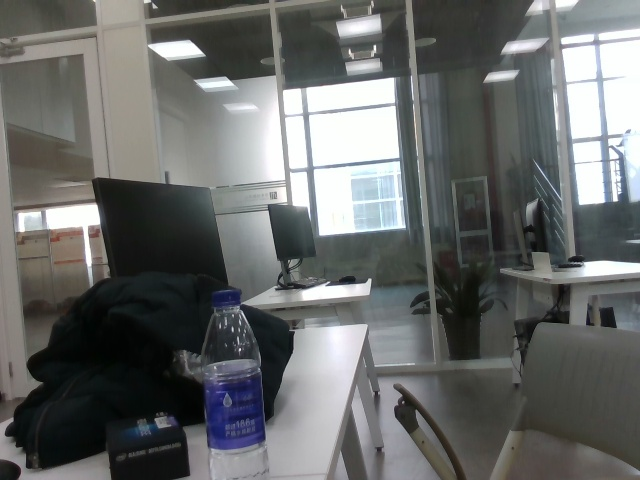

Answer:
The image depicts an office environment with several elements visible:

1. **Foreground**: 
   - A white desk with a black jacket draped over it.
   - A clear plastic water bottle labeled "Evian" is placed on the desk.

2. **Middle Ground**:
   - Two computer monitors are positioned on desks, suggesting a workspace setup.
   - The monitors are turned off, indicating that the office might not currently be in use or it's after working hours.

3. **Background**:
   - Glass partitions divide the space, providing a sense of openness and separation between different work areas.
   - There are additional desks and chairs visible through the glass, hinting at a larger office layout.
   - A potted plant is placed near one of the desks, adding a touch of greenery to the environment.

4. **Lighting and Windows**:
   - The room is well-lit with natural light coming through the large windows, enhancing visibility and creating a pleasant atmosphere.
   - The windows provide a view of the out

In [16]:

from transformers import TextStreamer

def load_pil_images(conversations):
    """

    Args:
        conversations (List[Dict[str, str]]): the conversations with a list of messages. An example is :
            [
                {
                    "role": "User",
                    "content": "<image>\nExtract all information from this image and convert them into markdown format.",
                    "images": ["./examples/table_datasets.png"]
                },
                {"role": "Assistant", "content": ""},
            ]

    Returns:
        pil_images (List[PIL.Image.Image]): the list of PIL images.

    """

    pil_images = []

    for message in conversations:
        if "images" not in message:
            continue

        for image_path in message["images"]:
            pil_img = PIL.Image.open(image_path)
            pil_img = pil_img.convert("RGB")
            pil_images.append(pil_img)

    return pil_images
    
conversation = [
    {
        "role": "<|User|>",
        "content": "<image>\nDescribe each stage of this image in detail",
        "images": ["DeepSeek-VL2/images/test.jpg"],
    },
    {"role": "<|Assistant|>", "content": ""},
]

pil_images = load_pil_images(conversation)
prepare_inputs = processor(conversations=conversation, images=pil_images, force_batchify=True, system_prompt="")
print(f"Question: {conversation[0]['content'].replace('<image>', '')}")
display(pil_images[-1])
inputs_embeds = ov_model.prepare_inputs_embeds(**prepare_inputs)
print("Answer:")

# run the model to get the response
outputs = ov_model.language_model.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=None,
    pad_token_id=processor.tokenizer.eos_token_id,
    bos_token_id=processor.tokenizer.bos_token_id,
    eos_token_id=processor.tokenizer.eos_token_id,
    past_key_values=None,
    input_ids=None,
    max_new_tokens=512,
    do_sample=False,
    use_cache=True,
    streamer=TextStreamer(processor.tokenizer, skip_special_tokens=True),
)

answer = processor.tokenizer.batch_decode(outputs, skip_special_tokens=False)

vg_image = parse_ref_bbox(answer[0], image=pil_images[-1])

if vg_image is not None:
    display(vg_image)

## Interactive demo
[back to top ⬆️](#Table-of-contents:)

In [ ]:
from gradio_helper import make_demo

demo = make_demo(ov_model, processor)

try:
    demo.launch(debug=True)
except Exception:
    demo.launch(debug=True, share=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/